# Building the Civic Issue Classifier

https://medium.com/@saad.arshad102/sentiment-analysis-text-classification-using-rnn-bi-lstm-recurrent-neural-network-81086dda8472
https://www.tensorflow.org/tutorials/text/text_classification_rnn

!pip install gensim

In [1]:
import pandas as pd
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
#import tensorflow as tf
from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

temp = pd.read_csv('finalData.csv')
data = pd.DataFrame()
data = temp[['description', 'civic_issue']].copy()
data.head()
len(data)

[nltk_data] Downloading package punkt to /home/shriya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


32120

In [2]:
#number of rows, columns
data.shape 

#number of positive, negative (positive -> civic, negative -> non civic)
data.civic_issue.value_counts()
data.head()

,description,civic_issue
0,Garbage behind the temple,1
1,Air pollution,1
2,Air pollution in hebbal,1
3,Garbage is dumped near BES,1
4,Leaf and garbage burning on Shakthi Ganapathi ...,1


In [3]:
#data cleaning
# 1) we remove punctuation marks

def remove_punctuation(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    #text_nopunct = str.maketrans('', '', string.punctuation)
    return text_nopunct
data['Text_Clean'] = data['description'].apply(lambda x: remove_punctuation(x))

print(data['Text_Clean'])

0                                Garbage behind the temple
1                                            Air pollution
2                                  Air pollution in hebbal
3                               Garbage is dumped near BES
4        Leaf and garbage burning on Shakthi Ganapathi ...
                               ...                        
32115    gets new phone hopefully tomorrow but mail doe...
32116    LeslieG stack is injured  are you a rowdy fan ...
32117                        ryanbader  Bummerlove Chuck  
32118         Kinda sad that my show time is over for now 
32119              good night and its still only day four 
Name: Text_Clean, Length: 32120, dtype: object


In [4]:
# 2) tokenisation (split the sentences into its respective words)
tokens = [(word_tokenize(str(sen))) for sen in data.Text_Clean]


In [5]:
# 3) convert these tokenised words into their lower cases
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [6]:
# 4) remove the stopwords using NLTK's stopwords
stoplist = stopwords.words('english')
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]
filtered_words = [removeStopWords(sen) for sen in lower_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [7]:
# since we have a binary category model (civic issue or non civic issue), 
#we add two one hot encoded columns to our data frame

civic = []
non_civic = []
for l in data.civic_issue:
    if l == 0:
        civic.append(0)
        non_civic.append(1)
    elif l == 1:
        civic.append(1)
        non_civic.append(0)
data['Civic']= civic
data['Non_Civic']= non_civic
data = data[['Text_Final', 'tokens', 'civic_issue', 'Civic', 'Non_Civic']]
data.head()

,Text_Final,tokens,civic_issue,Civic,Non_Civic
0,garbage behind temple,"[garbage, behind, temple]",1,1,0
1,air pollution,"[air, pollution]",1,1,0
2,air pollution hebbal,"[air, pollution, hebbal]",1,1,0
3,garbage dumped near bes,"[garbage, dumped, near, bes]",1,1,0
4,leaf garbage burning shakthi ganapathi temple ...,"[leaf, garbage, burning, shakthi, ganapathi, t...",1,1,0


In [8]:
# we split the data into training and testing. i have taken 80-20. 
# not entirely sure if we should use the 'random_state' parameter.

data_train, data_test = train_test_split(data, test_size=0.20, random_state=42)

In [9]:
# we find the total number of words in our training dataset and find max sentence lengeth.

all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

263691 words total, with a vocabulary size of 34562
Max sentence length is 47


In [10]:
# repeat same thing for the test dataset.

all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

#print(all_test_words)

65832 words total, with a vocabulary size of 13859
Max sentence length is 44


## Building the RNN

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/



In [12]:
'''from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import numpy as np 
# fix random seed for reproducibility
np.random.seed(7)'''

'from keras.models import Sequential\nfrom keras.layers import Dense, Dropout\nfrom keras.layers import LSTM\nfrom keras.layers.embeddings import Embedding\nfrom keras.preprocessing import sequence\nimport numpy as np \n# fix random seed for reproducibility\nnp.random.seed(7)'

In [13]:
'''# Newly added Cell
dataset = data[['tokens','civic_issue']]'''

"# Newly added Cell\ndataset = data[['tokens','civic_issue']]"

In [14]:
#train,test = train_test_split(dataset,test_size=0.20, random_state=42)

In [15]:
'''max_length = 45
X_train = sequence.pad_sequences(train, maxlen=max_length)
X_test = sequence.pad_sequences(test, maxlen=max_length)'''

'max_length = 45\nX_train = sequence.pad_sequences(train, maxlen=max_length)\nX_test = sequence.pad_sequences(test, maxlen=max_length)'

In [16]:
# embedding_vecor_length = 32
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# model.add(Dropout(0.2))
# model.add(LSTM(100))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
# model.fit(X_train, y_train, epochs=3, batch_size=64)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [22]:
# creating a word embedding

sentences = []
for words in data['tokens']:
    sentences.append(words)
    
#for i in range(1,20):
#    print(sentences[i])

# train model
model = Word2Vec(sentences, min_count=1)

# summarize the loaded model
#print(model)

# summarize vocabulary
words = list(model.wv.vocab)
#print(words)

# access vector for one word
#print(model['sentence'])

# save model
model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')
#print(new_model)


['garbage', 'behind', 'temple', 'air', 'pollution', 'hebbal', 'dumped', 'near', 'bes', 'leaf', 'burning', 'shakthi', 'ganapathi', 'premises', 'action', 'taken', 'despite', 'complaints', 'lot', 'dump', 'around', 'area', 'lots', 'small', 'petty', 'shops', 'food', 'carts', 'located', 'disposable', 'paper', 'cups', 'thrown', 'find', 'way', 'storm', 'water', 'drains', 'replace', 'broken', 'streetlight', 'complaint', '5', 'red', 'matiz', 'parked', 'footpath', '6', 'months', 'police', 'repeated', 'requests', 'cars', 'using', 'parking', 'space', 'everyday', 'year', 'place', 'pedestrians', 'damaging', 'congestion', 'times', 'due', 'improper', 'roads', 'construction', 'congestiom', 'time', 'mud', 'traffic', 'jam', 'sign', 'placed', 'vehicles', 'road', 'flies', 'rodents', 'seen', 'ads', 'stuck', 'theyre', 'coming', 'even', 'try', 'called', 'asked', 'remove', 'still', 'havent', 'cables', 'hanging', 'open', 'loose', 'ends', 'bus', 'wrongly', 'blocking', 'creating', 'waste', 'side', 'garbade', 'infr

<ipython-input-12-fb5b48816a03>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


'w = list(model.wv.vocab)\nfor i, word in enumerate(w):\n    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))\npyplot.show()'

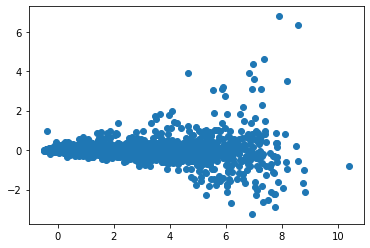

In [12]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])

#see if u can get the below code to work.
'''w = list(model.wv.vocab)
for i, word in enumerate(w):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()'''


In [13]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [15]:

tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 34560 unique tokens.


In [16]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
import numpy as np

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = words[word] if word in words else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

TypeError: list indices must be integers or slices, not str

In [30]:
print(words)
print(train_word_index)

['garbage', 'behind', 'temple', 'air', 'pollution', 'hebbal', 'dumped', 'near', 'bes', 'leaf', 'burning', 'shakthi', 'ganapathi', 'premises', 'action', 'taken', 'despite', 'complaints', 'lot', 'dump', 'around', 'area', 'lots', 'small', 'petty', 'shops', 'food', 'carts', 'located', 'disposable', 'paper', 'cups', 'thrown', 'find', 'way', 'storm', 'water', 'drains', 'replace', 'broken', 'streetlight', 'complaint', '5', 'red', 'matiz', 'parked', 'footpath', '6', 'months', 'police', 'repeated', 'requests', 'cars', 'using', 'parking', 'space', 'everyday', 'year', 'place', 'pedestrians', 'damaging', 'congestion', 'times', 'due', 'improper', 'roads', 'construction', 'congestiom', 'time', 'mud', 'traffic', 'jam', 'sign', 'placed', 'vehicles', 'road', 'flies', 'rodents', 'seen', 'ads', 'stuck', 'theyre', 'coming', 'even', 'try', 'called', 'asked', 'remove', 'still', 'havent', 'cables', 'hanging', 'open', 'loose', 'ends', 'bus', 'wrongly', 'blocking', 'creating', 'waste', 'side', 'garbade', 'infr